# Large Scale Distributed Seismic Processing

In this notebook we will work with a much larger dataset.  Here we have a 180GB SEGY file containing raw pre-stack seismic data.  Lets take a look at this dataset and then do the same mean amplitude calculations, using only a basic T3.Medium instance.

### Import packages

In [1]:
import sys
import time
import json
import boto3
import struct
import pickle
import botocore
import array as arr
import numpy as np
import matplotlib.pyplot as plt
from struct import Struct

### Functions

We will reuse the SEGY loading functions from before, so lets define them all in one go.

In [2]:
def DecodeTextHeader(text_header_raw):
    text_header = text_header_raw.decode('cp500')
    text_header = text_header.replace("C 1 ", "\nC 1 ")
    text_header = text_header.replace("C 2 ", "\nC 2 ")
    text_header = text_header.replace("C 3 ", "\nC 3 ")
    text_header = text_header.replace("C 4 ", "\nC 4 ")
    text_header = text_header.replace("C 5 ", "\nC 5 ")
    text_header = text_header.replace("C 6 ", "\nC 6 ")
    text_header = text_header.replace("C 7 ", "\nC 7 ")
    text_header = text_header.replace("C 8 ", "\nC 8 ")
    text_header = text_header.replace("C 9 ", "\nC 9 ")
    text_header = text_header.replace("C10 ", "\nC10 ")
    text_header = text_header.replace("C11 ", "\nC11 ")
    text_header = text_header.replace("C12 ", "\nC12 ")
    text_header = text_header.replace("C13 ", "\nC13 ")
    text_header = text_header.replace("C14 ", "\nC14 ")
    text_header = text_header.replace("C15 ", "\nC15 ")
    text_header = text_header.replace("C16 ", "\nC16 ")
    text_header = text_header.replace("C17 ", "\nC17 ")
    text_header = text_header.replace("C18 ", "\nC18 ")
    text_header = text_header.replace("C19 ", "\nC19 ")
    text_header = text_header.replace("C20 ", "\nC20 ")
    text_header = text_header.replace("C21 ", "\nC21 ")
    text_header = text_header.replace("C22 ", "\nC22 ")
    text_header = text_header.replace("C23 ", "\nC23 ")
    text_header = text_header.replace("C24 ", "\nC24 ")
    text_header = text_header.replace("C25 ", "\nC25 ")
    text_header = text_header.replace("C26 ", "\nC26 ")
    text_header = text_header.replace("C27 ", "\nC27 ")
    text_header = text_header.replace("C28 ", "\nC28 ")
    text_header = text_header.replace("C29 ", "\nC29 ")
    text_header = text_header.replace("C30 ", "\nC30 ")
    text_header = text_header.replace("C31 ", "\nC31 ")
    text_header = text_header.replace("C32 ", "\nC32 ")
    text_header = text_header.replace("C33 ", "\nC33 ")
    text_header = text_header.replace("C34 ", "\nC34 ")
    text_header = text_header.replace("C35 ", "\nC35 ")
    text_header = text_header.replace("C36 ", "\nC36 ")
    text_header = text_header.replace("C37 ", "\nC37 ")
    text_header = text_header.replace("C38 ", "\nC38 ")
    text_header = text_header.replace("C39 ", "\nC39 ")
    text_header = text_header.replace("C40 ", "\nC40 ")
    
    return text_header


def DecodeBinHeader(bin_header_raw):
    bin_header = {}

    bin_header['job_id']                  = int.from_bytes(bin_header_raw[0:4], byteorder='big', signed=False)
    bin_header['line_no']                 = int.from_bytes(bin_header_raw[4:8], byteorder='big', signed=False)
    bin_header['reel_no']                 = int.from_bytes(bin_header_raw[8:12], byteorder='big', signed=False)
    bin_header['data_traces']             = int.from_bytes(bin_header_raw[12:14], byteorder='big', signed=False)
    bin_header['aux_traces']              = int.from_bytes(bin_header_raw[14:16], byteorder='big', signed=False)
    bin_header['sample_interval']         = int.from_bytes(bin_header_raw[16:18], byteorder='big', signed=False)
    bin_header['sample_interval_orig']    = int.from_bytes(bin_header_raw[18:20], byteorder='big', signed=False)
    bin_header['samples_per_trace']       = int.from_bytes(bin_header_raw[20:22], byteorder='big', signed=False)
    bin_header['samples_per_trace_orig']  = int.from_bytes(bin_header_raw[22:24], byteorder='big', signed=False)
    bin_header['data_sample_format']      = int.from_bytes(bin_header_raw[24:26], byteorder='big', signed=False)
    bin_header['ensemble_fold']           = int.from_bytes(bin_header_raw[26:28], byteorder='big', signed=False)
    bin_header['trace_sorting']           = int.from_bytes(bin_header_raw[28:30], byteorder='big', signed=False)
    bin_header['vert_sum_code']           = int.from_bytes(bin_header_raw[30:32], byteorder='big', signed=False)
    bin_header['sweep_hz_start']          = int.from_bytes(bin_header_raw[32:34], byteorder='big', signed=False)
    bin_header['sweep_hz_end']            = int.from_bytes(bin_header_raw[34:36], byteorder='big', signed=False)
    bin_header['sweep_length']            = int.from_bytes(bin_header_raw[36:38], byteorder='big', signed=False)
    bin_header['sweep_type']              = int.from_bytes(bin_header_raw[38:40], byteorder='big', signed=False)
    bin_header['sweep_trace_ch']          = int.from_bytes(bin_header_raw[40:42], byteorder='big', signed=False)
    bin_header['sweep_trace_taper_start'] = int.from_bytes(bin_header_raw[42:44], byteorder='big', signed=False)
    bin_header['sweep_trace_taper_end']   = int.from_bytes(bin_header_raw[44:46], byteorder='big', signed=False)
    bin_header['taper_type']              = int.from_bytes(bin_header_raw[46:48], byteorder='big', signed=False)
    bin_header['data_traces_correlated']  = int.from_bytes(bin_header_raw[48:50], byteorder='big', signed=False)
    bin_header['binary_gain_recovered']   = int.from_bytes(bin_header_raw[50:52], byteorder='big', signed=False)
    bin_header['amp_recovery_method']     = int.from_bytes(bin_header_raw[52:54], byteorder='big', signed=False)
    bin_header['measurement_system']      = int.from_bytes(bin_header_raw[54:56], byteorder='big', signed=False)
    bin_header['impulse_sig_polarity']    = int.from_bytes(bin_header_raw[56:58], byteorder='big', signed=False)
    bin_header['vib_polarity']            = int.from_bytes(bin_header_raw[58:60], byteorder='big', signed=False)
    bin_header['unassigned']              = int.from_bytes(bin_header_raw[60:300], byteorder='big', signed=False)
    bin_header['segy_format']             = int.from_bytes(bin_header_raw[300:302], byteorder='big', signed=False)
    bin_header['fixed_length_flag']       = int.from_bytes(bin_header_raw[302:304], byteorder='big', signed=False)
    bin_header['extended_text_header_no'] = int.from_bytes(bin_header_raw[304:306], byteorder='big', signed=False)
    bin_header['unassigned2']             = int.from_bytes(bin_header_raw[306:400], byteorder='big', signed=False)
    
    return bin_header


def PrintBinHeader(bin_header):
    print("job_id                  = ", bin_header['job_id']                 )
    print("line_no                 = ", bin_header['line_no']                )
    print("reel_no                 = ", bin_header['reel_no']                )
    print("data_traces             = ", bin_header['data_traces']            )
    print("aux_traces              = ", bin_header['aux_traces']             )
    print("sample_interval         = ", bin_header['sample_interval']        )
    print("sample_interval_orig    = ", bin_header['sample_interval_orig']   )
    print("samples_per_trace       = ", bin_header['samples_per_trace']      )
    print("samples_per_trace_orig  = ", bin_header['samples_per_trace_orig'] )
    print("data_sample_format      = ", bin_header['data_sample_format']     )
    print("ensemble_fold           = ", bin_header['ensemble_fold']          )
    print("trace_sorting           = ", bin_header['trace_sorting']          )
    print("vert_sum_code           = ", bin_header['vert_sum_code']          )
    print("sweep_hz_start          = ", bin_header['sweep_hz_start']         )
    print("sweep_hz_end            = ", bin_header['sweep_hz_end']           )
    print("sweep_length            = ", bin_header['sweep_length']           )
    print("sweep_type              = ", bin_header['sweep_type']             )
    print("sweep_trace_ch          = ", bin_header['sweep_trace_ch']         )
    print("sweep_trace_taper_start = ", bin_header['sweep_trace_taper_start'])
    print("sweep_trace_taper_end   = ", bin_header['sweep_trace_taper_end']  )
    print("taper_type              = ", bin_header['taper_type']             )
    print("data_traces_correlated  = ", bin_header['data_traces_correlated'] )
    print("binary_gain_recovered   = ", bin_header['binary_gain_recovered']  )
    print("amp_recovery_method     = ", bin_header['amp_recovery_method']    )
    print("measurement_system      = ", bin_header['measurement_system']     )
    print("impulse_sig_polarity    = ", bin_header['impulse_sig_polarity']   )
    print("vib_polarity            = ", bin_header['vib_polarity']           )
    print("unassigned              = ", bin_header['unassigned']             )
    print("segy_format             = ", bin(bin_header['segy_format'])[2:]   )    
    print("fixed_length_flag       = ", bin_header['fixed_length_flag']      )
    print("extended_text_header_no = ", bin_header['extended_text_header_no'])
    print("unassigned2             = ", bin_header['unassigned2']            )
    
    
def DecodeTraceHeader(trace_header_raw):
    trace_header = {}
    trace_header['trace_seq_no_all']            = int.from_bytes(trace_header_raw[0:4], byteorder='big', signed=False)
    trace_header['trace_seq_no_file']           = int.from_bytes(trace_header_raw[4:8], byteorder='big', signed=False)
    trace_header['field_record_no_orig']        = int.from_bytes(trace_header_raw[8:12], byteorder='big', signed=False)
    trace_header['trace_no_field_orig']         = int.from_bytes(trace_header_raw[12:16], byteorder='big', signed=False)
    trace_header['energy_source_point_no']      = int.from_bytes(trace_header_raw[16:20], byteorder='big', signed=False)
    trace_header['ensemble_no']                 = int.from_bytes(trace_header_raw[20:24], byteorder='big', signed=False)
    trace_header['ensemble_trace_no']           = int.from_bytes(trace_header_raw[24:28], byteorder='big', signed=False)
    trace_header['trace_id']                    = int.from_bytes(trace_header_raw[28:30], byteorder='big', signed=False)
    trace_header['sum_vertical_traces']         = int.from_bytes(trace_header_raw[30:32], byteorder='big', signed=False)
    trace_header['sum_horizontal_traces']       = int.from_bytes(trace_header_raw[32:34], byteorder='big', signed=False)
    trace_header['data_use']                    = int.from_bytes(trace_header_raw[34:36], byteorder='big', signed=False)
    trace_header['distance_from_source_center'] = int.from_bytes(trace_header_raw[36:40], byteorder='big', signed=False)
    # ... incomplete
    trace_header['group_x']                     = int.from_bytes(trace_header_raw[80:84], byteorder='big', signed=False)
    trace_header['group_y']                     = int.from_bytes(trace_header_raw[84:88], byteorder='big', signed=False)
    trace_header['coord_units']                 = int.from_bytes(trace_header_raw[88:90], byteorder='big', signed=False)
    trace_header['trace_samples']               = int.from_bytes(trace_header_raw[114:116], byteorder='big', signed=False)
    trace_header['sample_interval']             = int.from_bytes(trace_header_raw[116:118], byteorder='big', signed=False)
    trace_header['gain_type']                   = int.from_bytes(trace_header_raw[118:120], byteorder='big', signed=False)
    trace_header['CDP_X']                       = int.from_bytes(trace_header_raw[180:184], byteorder='big', signed=False)
    trace_header['CDP_Y']                       = int.from_bytes(trace_header_raw[184:188], byteorder='big', signed=False)
    trace_header['inline']                      = int.from_bytes(trace_header_raw[188:192], byteorder='big', signed=False)
    trace_header['xline']                       = int.from_bytes(trace_header_raw[192:196], byteorder='big', signed=False)
    trace_header['trace_unit']                  = int.from_bytes(trace_header_raw[202:204], byteorder='big', signed=False) 
    trace_header['inline_custom']               = int.from_bytes(trace_header_raw[232:236], byteorder='big', signed=False)
    trace_header['xline_custom']                = int.from_bytes(trace_header_raw[236:240], byteorder='big', signed=False)

    return trace_header
    

def PrintTraceHeaders(trace_header):
    print("trace_seq_no_all            = ", trace_header['trace_seq_no_all'])
    print("trace_seq_no_file           = ", trace_header['trace_seq_no_file'])
    print("field_record_no_orig        = ", trace_header['field_record_no_orig'])
    print("trace_no_field_orig         = ", trace_header['trace_no_field_orig'])
    print("energy_source_point_no      = ", trace_header['energy_source_point_no'])
    print("ensemble_no                 = ", trace_header['ensemble_no'])
    print("ensemble_trace_no           = ", trace_header['ensemble_trace_no'])
    print("trace_id                    = ", trace_header['trace_id'])
    print("sum_vertical_traces         = ", trace_header['sum_vertical_traces'])
    print("sum_horizontal_traces       = ", trace_header['sum_horizontal_traces'])
    print("data_use                    = ", trace_header['data_use'])
    print("distance_from_source_center = ", trace_header['distance_from_source_center'])
    # ... incomplete
    print("group_x                     = ", trace_header['group_x'])
    print("group_y                     = ", trace_header['group_y'])
    print("coord_units                 = ", trace_header['coord_units'])
    print("trace_samples               = ", trace_header['trace_samples'])
    print("sample_interval             = ", trace_header['sample_interval'])
    print("gain_type                   = ", trace_header['gain_type'])
    print("CDP_X                       = ", trace_header['CDP_X'])          
    print("CDP_Y                       = ", trace_header['CDP_Y'])          
    print("inline                      = ", trace_header['inline'])         
    print("xline                       = ", trace_header['xline'])          
    print("trace_unit                  = ", trace_header['trace_unit'])     
    print("inline_custom               = ", trace_header['inline_custom'])         
    print("xline_custom                = ", trace_header['xline_custom'])          


### Load SEGY File

Lets load in the large 180GB SEGY file as a data stream.

In [3]:
# Load in the 180GB raw pre-stack SEGY data

source_bucket   = 'equinor-volve-data-village'                  # S3 bucket name with input data
source_folder   = 'Seismic/ST10010/Raw_data/ST10010+NAV_MERGE'  # Folder path
source_filename = 'ST10010_1150780_40203.sgy'                   # Filename

s3 = boto3.resource('s3')
segy_obj = s3.Object(source_bucket, f"{source_folder}/{source_filename}")
segy_stream = segy_obj.get()['Body']

### Read Headers

Lets read the text and binary headers.  We will see that this file does not follow SEGY revision 1 standard as before and has custom trace header byte locations for some information.  We will not be using that data for this notebook.  If we did, we would need to adapt our function above to query the correct locations.

In [4]:
text_header_raw = segy_stream.read(3200)
bin_header_raw = segy_stream.read(400)

text_header = DecodeTextHeader(text_header_raw)

print("Text Header:")
print(text_header)

bin_header = DecodeBinHeader(bin_header_raw)
print("\nBinary Header:")
PrintBinHeader(bin_header)

Text Header:

C 1 CLIENT: STATOIL           COMPANY: RESERVOIR EXPLORATION TECHNOLOGY         
C 2 AREA: VOLVE NORWAY BLOCK 15/9                SURVEY: ST10010                
C 3 SWATH:  11                             VESSELS:M/V VIKLAND, M/V SANCO SPIRIT
C 4 RCV LINE: 1150780    RCVR RANGE: 1239-1717                                  
C 5 DATA-SET: NAV MERGE   TRACES PER RECORD: 240 X 4   SEQ: 094-133             
C 6 RECORDING FORMAT: IEEE SEG-Y           FORMAT THIS REEL: SEG-Y 3592         
C 7 SAMPLE CODE: FLOATING PT               PROCESSED: 03/11/2010                
C 8 ACQ. GEOM: 8 ROLL 8  INLINE SWATH      LINE PREFIX: ST10010                 
C 9 INSTRUMENT: VECTORSEIS OCEAN BOTTOM    RECORDING SYSTEM DELAY: 0 MS         
C10 RECORDING FILTER: 1.5/6-187/260MIN PHS DESCRIPTION: HZ/DB PER OCTAVE        
C11 NO OF RECEIVER LINES/SWATH: 8          RECEIVER LINE SEPARATION: 400/200M   
C12 ACTIVE CABLE LENGTH: 5975M             RCVRS / RCV LINE 240 X 4             
C13 NO OF SOUR

### Trace Headers

Reading the first trace header.  Notice CDP X/Y and inline/xline values are not correct, as they are stored at another byte location.

In [5]:
trace_header_raw = segy_stream.read(240)

trace_header = DecodeTraceHeader(trace_header_raw)
PrintTraceHeaders(trace_header)

trace_seq_no_all            =  1
trace_seq_no_file           =  28801
field_record_no_orig        =  1000
trace_no_field_orig         =  1
energy_source_point_no      =  1000
ensemble_no                 =  10205120
ensemble_trace_no           =  0
trace_id                    =  1
sum_vertical_traces         =  0
sum_horizontal_traces       =  0
data_use                    =  1
distance_from_source_center =  3109
group_x                     =  4311640
group_y                     =  64776128
coord_units                 =  1
trace_samples               =  5000
sample_interval             =  2000
gain_type                   =  1
CDP_X                       =  0
CDP_Y                       =  720896
inline                      =  65792
xline                       =  0
trace_unit                  =  50100
inline_custom               =  1020
xline_custom                =  5120


### Trace Data

Lets read in the first trace and plot it.  In this file the trace data is in IEEE 4-byte float, which is useable in Python.  We do not need to convert it, but only unpack it from the byte format.

This raw data looks very different than the processed data we saw before, as it does not have any amplitude gain applied.

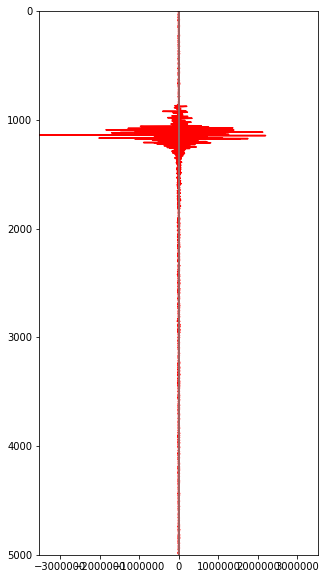

In [6]:
trace_raw = segy_stream.read(trace_header['trace_samples']*4)

trace = []
for x in range(4, trace_header['trace_samples']*4+4, 4):
    trace.append(struct.unpack('>f', trace_raw[x-4:x])[0])

# Lets plot the trace
limits = np.amax(np.absolute(trace))
plt.figure(figsize=(5, 10))
plt.plot(trace, range(trace_header['trace_samples']), 'red')
plt.xlim(-limits, limits)
plt.ylim(trace_header['trace_samples'], 0)
plt.axvline(0, c='grey')


segy_stream.close()

### Process Data

Great, we are loading the data correctly.  Now to scale this out across multiple Lambdas.

First, for a benchmark, lets start processing here and see how long it might take.  Keep in mind we are using a small T2.Medium instance and only using 1 CPU core, as we are not threading the calculations.

In [7]:
segy_stream = segy_obj.get()['Body']

text_header_raw = segy_stream.read(3200)
bin_header_raw = segy_stream.read(400)
text_header = DecodeTextHeader(text_header_raw)
bin_header = DecodeBinHeader(bin_header_raw)

In [8]:
trace_amp_mean = {}
start_time = time.time()

# Iterate through all the traces
while True:
    trace_header_raw = segy_stream.read(240)
    trace_header = DecodeTraceHeader(trace_header_raw)
    trace_raw = segy_stream.read(trace_header['trace_samples']*4)

    trace = []
    for x in range(4, trace_header['trace_samples']*4+4, 4):
        trace.append(struct.unpack('>f', trace_raw[x-4:x])[0])
    
    trace_amp_mean[trace_header['trace_seq_no_all']] = np.mean(np.absolute(trace))
    
    if trace_header['trace_seq_no_all']%1000 == 0:
        print("Trace #{} has a mean amplitude of {}, elapse time is {:.2f} seconds.".format(
                                        trace_header['trace_seq_no_all'], 
                                        trace_amp_mean[trace_header['trace_seq_no_all']], 
                                        time.time() - start_time))
        
    if trace_header['trace_seq_no_all'] > 5000:
        print("Stopping here.")
        break

segy_stream.close()

Trace #1000 has a mean amplitude of 565.3708463373408, elapse time is 2.89 seconds.
Trace #2000 has a mean amplitude of 514.2147184047617, elapse time is 5.78 seconds.
Trace #3000 has a mean amplitude of 476.82839872567655, elapse time is 8.68 seconds.
Trace #4000 has a mean amplitude of 552.2220116226882, elapse time is 11.57 seconds.
Trace #5000 has a mean amplitude of 483.42787134556283, elapse time is 14.46 seconds.
Stopping here.


### Scale Out

So thats about 2-3 seconds per 1,000 traces.  Problem is that there are about 9,300,000 traces in this file.  That would take about 6 hours.  Plus the entire raw dataset for the seismic cube contains many such 180GB files.

We could scale up and use a 16xLarge instance (64 CPUs) and start threading the calculations.  This might take then take about 6 mins to process, but now we have have file bandwidth bottlenecks.  It takes about 75 minutes to read through the file from S3 to this notebook from end to end.  Further downside is that you have to do the undiferentiated heavy lifting of provisioning the hardware resources for the notebook and starting/stopping them as needed to save costs.  The T3.16xLarge instance cost is about \\$3/hour, versus $0.03/hour for our T2.Medium.

So lets use Lambda again to process the file.  No need for provisioning resources.  With our current default limits, we can have 1000 concurrent Lambdas running, so we will use them all!  This limit can be increased if needed (and should, if doing seismic processing like this).

Lets get things setup up below.

In [9]:
lambda_name        = "SegyBatchProcessMeanAmp"             # Name of the Lambda function to invoke
results_bucket     = "vavourak-demo-temp"                  # Bucket to use
mean_amp_folder    = "temp-trace-bundles-st10010-mean-amp" # Subfolder to place the calculation results
concurrent_lambdas = 1000                                  # Number of Lambdas to invoke

Now lets split up the SEGY file into byte ranges and invoke 1000 Lambda functions.

In [10]:
# Get S3 object
segy_obj = s3.Object(source_bucket, f"{source_folder}/{source_filename}")

# Define some needed variables based off the above parameters
start_time = time.time()
header_size = 3600
trace_header_size = 240
trace_size = bin_header['samples_per_trace'] * 4
trace_size_with_headers = trace_size + trace_header_size
filesize = segy_obj.content_length
trace_count = int((filesize - 3600) / trace_size_with_headers)
bundle_size = round(trace_count/concurrent_lambdas)
lambda_counter = 0

lambda_client = boto3.client('lambda')

results_file_list = [] # Lets keep track of the output file names, so we can grab them later

print(f"Total traces in file: {trace_count}")
print(f"Traces per Lambda for {concurrent_lambdas} concurrency (not rounded): {trace_count/concurrent_lambdas}")
print(f"Traces per Lambda, rounded up: {round(trace_count/concurrent_lambdas+0.5)}")

# Send the trace bundle information over to Lambda
for bundle in range(0, int(trace_count), bundle_size):
    lambda_counter = lambda_counter + 1
    bytes_start = bundle * trace_size_with_headers + header_size
    bytes_stop = (bundle + bundle_size) * trace_size_with_headers + header_size - 1
    print(f"Lambda #{lambda_counter}, bundled traces: {bundle}-{bundle+bundle_size}, bytes: {bytes_start}-{bytes_stop}.")
    
    # Build the message for the Lambda to find the files
    payload = {
        "bucket_in"          : source_bucket,
        "folder_in"          : source_folder,
        "filename_in"        : source_filename,
        "bucket_out"         : results_bucket,
        "folder_out"         : mean_amp_folder,
        "bytes_start"        : bytes_start,
        "bytes_stop"         : bytes_stop,
        "use_custom_lines"   : 1,
        "data_sample_format" : bin_header['data_sample_format']
    }

    # Invoke the Lambda SegyBatchProcessMeanAmp
    response = lambda_client.invoke(FunctionName=lambda_name,
                                    InvocationType='Event',
                                    Payload=json.dumps(payload))

    results_file_list.append(f"{mean_amp_folder}/{source_filename}.{bytes_start}-{bytes_stop}.pkl")
    
print("Done!  Elapse time to gather traces and send to Lambda: {:0.2f} seconds, now waiting a bit for processing to complete.".format(time.time() - start_time))

time.sleep(400)      # Waiting before carrying on next steps, to allow time for Lambda to finish.

Total traces in file: 9212160
Traces per Lambda for 1000 concurrency (not rounded): 9212.16
Traces per Lambda, rounded up: 9213
Lambda #1, bundled traces: 0-9212, bytes: 3600-186454479.
Lambda #2, bundled traces: 9212-18424, bytes: 186454480-372905359.
Lambda #3, bundled traces: 18424-27636, bytes: 372905360-559356239.
Lambda #4, bundled traces: 27636-36848, bytes: 559356240-745807119.
Lambda #5, bundled traces: 36848-46060, bytes: 745807120-932257999.
Lambda #6, bundled traces: 46060-55272, bytes: 932258000-1118708879.
Lambda #7, bundled traces: 55272-64484, bytes: 1118708880-1305159759.
Lambda #8, bundled traces: 64484-73696, bytes: 1305159760-1491610639.
Lambda #9, bundled traces: 73696-82908, bytes: 1491610640-1678061519.
Lambda #10, bundled traces: 82908-92120, bytes: 1678061520-1864512399.
Lambda #11, bundled traces: 92120-101332, bytes: 1864512400-2050963279.
Lambda #12, bundled traces: 101332-110544, bytes: 2050963280-2237414159.
Lambda #13, bundled traces: 110544-119756, bytes

Lambda #111, bundled traces: 1013320-1022532, bytes: 20509600400-20696051279.
Lambda #112, bundled traces: 1022532-1031744, bytes: 20696051280-20882502159.
Lambda #113, bundled traces: 1031744-1040956, bytes: 20882502160-21068953039.
Lambda #114, bundled traces: 1040956-1050168, bytes: 21068953040-21255403919.
Lambda #115, bundled traces: 1050168-1059380, bytes: 21255403920-21441854799.
Lambda #116, bundled traces: 1059380-1068592, bytes: 21441854800-21628305679.
Lambda #117, bundled traces: 1068592-1077804, bytes: 21628305680-21814756559.
Lambda #118, bundled traces: 1077804-1087016, bytes: 21814756560-22001207439.
Lambda #119, bundled traces: 1087016-1096228, bytes: 22001207440-22187658319.
Lambda #120, bundled traces: 1096228-1105440, bytes: 22187658320-22374109199.
Lambda #121, bundled traces: 1105440-1114652, bytes: 22374109200-22560560079.
Lambda #122, bundled traces: 1114652-1123864, bytes: 22560560080-22747010959.
Lambda #123, bundled traces: 1123864-1133076, bytes: 22747010960

Lambda #218, bundled traces: 1999004-2008216, bytes: 40459844560-40646295439.
Lambda #219, bundled traces: 2008216-2017428, bytes: 40646295440-40832746319.
Lambda #220, bundled traces: 2017428-2026640, bytes: 40832746320-41019197199.
Lambda #221, bundled traces: 2026640-2035852, bytes: 41019197200-41205648079.
Lambda #222, bundled traces: 2035852-2045064, bytes: 41205648080-41392098959.
Lambda #223, bundled traces: 2045064-2054276, bytes: 41392098960-41578549839.
Lambda #224, bundled traces: 2054276-2063488, bytes: 41578549840-41765000719.
Lambda #225, bundled traces: 2063488-2072700, bytes: 41765000720-41951451599.
Lambda #226, bundled traces: 2072700-2081912, bytes: 41951451600-42137902479.
Lambda #227, bundled traces: 2081912-2091124, bytes: 42137902480-42324353359.
Lambda #228, bundled traces: 2091124-2100336, bytes: 42324353360-42510804239.
Lambda #229, bundled traces: 2100336-2109548, bytes: 42510804240-42697255119.
Lambda #230, bundled traces: 2109548-2118760, bytes: 42697255120

Lambda #327, bundled traces: 3003112-3012324, bytes: 60782990480-60969441359.
Lambda #328, bundled traces: 3012324-3021536, bytes: 60969441360-61155892239.
Lambda #329, bundled traces: 3021536-3030748, bytes: 61155892240-61342343119.
Lambda #330, bundled traces: 3030748-3039960, bytes: 61342343120-61528793999.
Lambda #331, bundled traces: 3039960-3049172, bytes: 61528794000-61715244879.
Lambda #332, bundled traces: 3049172-3058384, bytes: 61715244880-61901695759.
Lambda #333, bundled traces: 3058384-3067596, bytes: 61901695760-62088146639.
Lambda #334, bundled traces: 3067596-3076808, bytes: 62088146640-62274597519.
Lambda #335, bundled traces: 3076808-3086020, bytes: 62274597520-62461048399.
Lambda #336, bundled traces: 3086020-3095232, bytes: 62461048400-62647499279.
Lambda #337, bundled traces: 3095232-3104444, bytes: 62647499280-62833950159.
Lambda #338, bundled traces: 3104444-3113656, bytes: 62833950160-63020401039.
Lambda #339, bundled traces: 3113656-3122868, bytes: 63020401040

Lambda #436, bundled traces: 4007220-4016432, bytes: 81106136400-81292587279.
Lambda #437, bundled traces: 4016432-4025644, bytes: 81292587280-81479038159.
Lambda #438, bundled traces: 4025644-4034856, bytes: 81479038160-81665489039.
Lambda #439, bundled traces: 4034856-4044068, bytes: 81665489040-81851939919.
Lambda #440, bundled traces: 4044068-4053280, bytes: 81851939920-82038390799.
Lambda #441, bundled traces: 4053280-4062492, bytes: 82038390800-82224841679.
Lambda #442, bundled traces: 4062492-4071704, bytes: 82224841680-82411292559.
Lambda #443, bundled traces: 4071704-4080916, bytes: 82411292560-82597743439.
Lambda #444, bundled traces: 4080916-4090128, bytes: 82597743440-82784194319.
Lambda #445, bundled traces: 4090128-4099340, bytes: 82784194320-82970645199.
Lambda #446, bundled traces: 4099340-4108552, bytes: 82970645200-83157096079.
Lambda #447, bundled traces: 4108552-4117764, bytes: 83157096080-83343546959.
Lambda #448, bundled traces: 4117764-4126976, bytes: 83343546960

Lambda #544, bundled traces: 5002116-5011328, bytes: 101242831440-101429282319.
Lambda #545, bundled traces: 5011328-5020540, bytes: 101429282320-101615733199.
Lambda #546, bundled traces: 5020540-5029752, bytes: 101615733200-101802184079.
Lambda #547, bundled traces: 5029752-5038964, bytes: 101802184080-101988634959.
Lambda #548, bundled traces: 5038964-5048176, bytes: 101988634960-102175085839.
Lambda #549, bundled traces: 5048176-5057388, bytes: 102175085840-102361536719.
Lambda #550, bundled traces: 5057388-5066600, bytes: 102361536720-102547987599.
Lambda #551, bundled traces: 5066600-5075812, bytes: 102547987600-102734438479.
Lambda #552, bundled traces: 5075812-5085024, bytes: 102734438480-102920889359.
Lambda #553, bundled traces: 5085024-5094236, bytes: 102920889360-103107340239.
Lambda #554, bundled traces: 5094236-5103448, bytes: 103107340240-103293791119.
Lambda #555, bundled traces: 5103448-5112660, bytes: 103293791120-103480241999.
Lambda #556, bundled traces: 5112660-512

Lambda #648, bundled traces: 5960164-5969376, bytes: 120633722960-120820173839.
Lambda #649, bundled traces: 5969376-5978588, bytes: 120820173840-121006624719.
Lambda #650, bundled traces: 5978588-5987800, bytes: 121006624720-121193075599.
Lambda #651, bundled traces: 5987800-5997012, bytes: 121193075600-121379526479.
Lambda #652, bundled traces: 5997012-6006224, bytes: 121379526480-121565977359.
Lambda #653, bundled traces: 6006224-6015436, bytes: 121565977360-121752428239.
Lambda #654, bundled traces: 6015436-6024648, bytes: 121752428240-121938879119.
Lambda #655, bundled traces: 6024648-6033860, bytes: 121938879120-122125329999.
Lambda #656, bundled traces: 6033860-6043072, bytes: 122125330000-122311780879.
Lambda #657, bundled traces: 6043072-6052284, bytes: 122311780880-122498231759.
Lambda #658, bundled traces: 6052284-6061496, bytes: 122498231760-122684682639.
Lambda #659, bundled traces: 6061496-6070708, bytes: 122684682640-122871133519.
Lambda #660, bundled traces: 6070708-607

Lambda #756, bundled traces: 6955060-6964272, bytes: 140770418000-140956868879.
Lambda #757, bundled traces: 6964272-6973484, bytes: 140956868880-141143319759.
Lambda #758, bundled traces: 6973484-6982696, bytes: 141143319760-141329770639.
Lambda #759, bundled traces: 6982696-6991908, bytes: 141329770640-141516221519.
Lambda #760, bundled traces: 6991908-7001120, bytes: 141516221520-141702672399.
Lambda #761, bundled traces: 7001120-7010332, bytes: 141702672400-141889123279.
Lambda #762, bundled traces: 7010332-7019544, bytes: 141889123280-142075574159.
Lambda #763, bundled traces: 7019544-7028756, bytes: 142075574160-142262025039.
Lambda #764, bundled traces: 7028756-7037968, bytes: 142262025040-142448475919.
Lambda #765, bundled traces: 7037968-7047180, bytes: 142448475920-142634926799.
Lambda #766, bundled traces: 7047180-7056392, bytes: 142634926800-142821377679.
Lambda #767, bundled traces: 7056392-7065604, bytes: 142821377680-143007828559.
Lambda #768, bundled traces: 7065604-707

Lambda #861, bundled traces: 7922320-7931532, bytes: 160347760400-160534211279.
Lambda #862, bundled traces: 7931532-7940744, bytes: 160534211280-160720662159.
Lambda #863, bundled traces: 7940744-7949956, bytes: 160720662160-160907113039.
Lambda #864, bundled traces: 7949956-7959168, bytes: 160907113040-161093563919.
Lambda #865, bundled traces: 7959168-7968380, bytes: 161093563920-161280014799.
Lambda #866, bundled traces: 7968380-7977592, bytes: 161280014800-161466465679.
Lambda #867, bundled traces: 7977592-7986804, bytes: 161466465680-161652916559.
Lambda #868, bundled traces: 7986804-7996016, bytes: 161652916560-161839367439.
Lambda #869, bundled traces: 7996016-8005228, bytes: 161839367440-162025818319.
Lambda #870, bundled traces: 8005228-8014440, bytes: 162025818320-162212269199.
Lambda #871, bundled traces: 8014440-8023652, bytes: 162212269200-162398720079.
Lambda #872, bundled traces: 8023652-8032864, bytes: 162398720080-162585170959.
Lambda #873, bundled traces: 8032864-804

Lambda #965, bundled traces: 8880368-8889580, bytes: 179738651920-179925102799.
Lambda #966, bundled traces: 8889580-8898792, bytes: 179925102800-180111553679.
Lambda #967, bundled traces: 8898792-8908004, bytes: 180111553680-180298004559.
Lambda #968, bundled traces: 8908004-8917216, bytes: 180298004560-180484455439.
Lambda #969, bundled traces: 8917216-8926428, bytes: 180484455440-180670906319.
Lambda #970, bundled traces: 8926428-8935640, bytes: 180670906320-180857357199.
Lambda #971, bundled traces: 8935640-8944852, bytes: 180857357200-181043808079.
Lambda #972, bundled traces: 8944852-8954064, bytes: 181043808080-181230258959.
Lambda #973, bundled traces: 8954064-8963276, bytes: 181230258960-181416709839.
Lambda #974, bundled traces: 8963276-8972488, bytes: 181416709840-181603160719.
Lambda #975, bundled traces: 8972488-8981700, bytes: 181603160720-181789611599.
Lambda #976, bundled traces: 8981700-8990912, bytes: 181789611600-181976062479.
Lambda #977, bundled traces: 8990912-900

With a 1000 Lambdas, taking roughly 330 seconds each, 60 seconds to start them, our total time is about 6.5 minutes.  The cost to perform this calculation on this 180GB file is about $0.67.  As it takes 60 seconds to invoke the Lambdas, there is some room for optimization here to invoke them faster.  Having more Lambda concurrency available will help too.

### Load Results
The Lambdas should be done by now. Lets load in the results from S3.

In [12]:
s3_client = boto3.client('s3')

traces = []
start_time = time.time()

# Iterate through the files
for x in range(0, len(results_file_list)):
    print("Reading file: ", results_file_list[x])
    
    # Get file from S3, convert from Pickle format
    object = s3_client.get_object(Bucket=results_bucket, Key=results_file_list[x])
    serializedObject = object['Body'].read()
    trace_bundle_temp = pickle.loads(serializedObject)
    
    for y in range(0, len(trace_bundle_temp)):
        traces.append(trace_bundle_temp[y])

print("Number of traces loaded: {}, elapsed time: {:0.2f} seconds.".format(len(trace_mean_amp), time.time() - start_time))


Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.3600-186454479.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.186454480-372905359.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.372905360-559356239.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.559356240-745807119.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.745807120-932257999.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.932258000-1118708879.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.1118708880-1305159759.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.1305159760-1491610639.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.1491610640-1678061519.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.1678061520-1

Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.15102524880-15288975759.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.15288975760-15475426639.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.15475426640-15661877519.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.15661877520-15848328399.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.15848328400-16034779279.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.16034779280-16221230159.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.16221230160-16407681039.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.16407681040-16594131919.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.16594131920-16780582799.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10

Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.29832144400-30018595279.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.30018595280-30205046159.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.30205046160-30391497039.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.30391497040-30577947919.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.30577947920-30764398799.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.30764398800-30950849679.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.30950849680-31137300559.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.31137300560-31323751439.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.31323751440-31510202319.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10

Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.44934665680-45121116559.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.45121116560-45307567439.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.45307567440-45494018319.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.45494018320-45680469199.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.45680469200-45866920079.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.45866920080-46053370959.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.46053370960-46239821839.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.46239821840-46426272719.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.46426272720-46612723599.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10

Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.60037186960-60223637839.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.60223637840-60410088719.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.60410088720-60596539599.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.60596539600-60782990479.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.60782990480-60969441359.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.60969441360-61155892239.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.61155892240-61342343119.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.61342343120-61528793999.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.61528794000-61715244879.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10

Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.74766806480-74953257359.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.74953257360-75139708239.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.75139708240-75326159119.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.75326159120-75512609999.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.75512610000-75699060879.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.75699060880-75885511759.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.75885511760-76071962639.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.76071962640-76258413519.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.76258413520-76444864399.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10

Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.89682876880-89869327759.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.89869327760-90055778639.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.90055778640-90242229519.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.90242229520-90428680399.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.90428680400-90615131279.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.90615131280-90801582159.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.90801582160-90988033039.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.90988033040-91174483919.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.91174483920-91360934799.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10

Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.104412496400-104598947279.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.104598947280-104785398159.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.104785398160-104971849039.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.104971849040-105158299919.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.105158299920-105344750799.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.105344750800-105531201679.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.105531201680-105717652559.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.105717652560-105904103439.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.105904103440-106090554319.pkl
Reading file:  temp-trace-bundles-st1

Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.118769214160-118955665039.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.118955665040-119142115919.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.119142115920-119328566799.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.119328566800-119515017679.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.119515017680-119701468559.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.119701468560-119887919439.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.119887919440-120074370319.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.120074370320-120260821199.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.120260821200-120447272079.pkl
Reading file:  temp-trace-bundles-st1

Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.133312382800-133498833679.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.133498833680-133685284559.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.133685284560-133871735439.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.133871735440-134058186319.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.134058186320-134244637199.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.134244637200-134431088079.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.134431088080-134617538959.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.134617538960-134803989839.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.134803989840-134990440719.pkl
Reading file:  temp-trace-bundles-st1

Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.147669100560-147855551439.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.147855551440-148042002319.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.148042002320-148228453199.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.148228453200-148414904079.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.148414904080-148601354959.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.148601354960-148787805839.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.148787805840-148974256719.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.148974256720-149160707599.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.149160707600-149347158479.pkl
Reading file:  temp-trace-bundles-st1

Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.162025818320-162212269199.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.162212269200-162398720079.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.162398720080-162585170959.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.162585170960-162771621839.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.162771621840-162958072719.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.162958072720-163144523599.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.163144523600-163330974479.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.163330974480-163517425359.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.163517425360-163703876239.pkl
Reading file:  temp-trace-bundles-st1

Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.176755437840-176941888719.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.176941888720-177128339599.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.177128339600-177314790479.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.177314790480-177501241359.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.177501241360-177687692239.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.177687692240-177874143119.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.177874143120-178060593999.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.178060594000-178247044879.pkl
Reading file:  temp-trace-bundles-st10010-mean-amp/ST10010_1150780_40203.sgy.178247044880-178433495759.pkl
Reading file:  temp-trace-bundles-st1

Plotting over 9 million traces will be taxing for Matplotlib.  Lets only show the max mean amplitude for each inline-xline location.  

In [13]:
traces_grouped = {}
traces_max = {}

# Go through every trace and make a dictionary with the values at each unique inline/xline location
counter = 0
for trace in traces:
    counter = counter + 1
    group = f"{trace[1]}-{trace[2]}"
    
    if group in traces_grouped:
        traces_grouped[str(group)].append(trace[0])
    else:
        traces_grouped[str(group)] = [trace[0]]

# Find the max amplitude at each location
for group in traces_grouped:
    traces_max[group] = np.amax(traces_grouped[group])

In [14]:
# Convert the dictionary back to arrays for easy consuption
traces_max_value = []
traces_max_inline = []
traces_max_xline = []

counter = 0
for group in traces_max:
    inline = int(group.split("-")[0])
    xline = int(group.split("-")[1])
    
    traces_max_inline.append(inline)
    traces_max_xline.append(xline)
    traces_max_value.append(traces_max[group])
    counter = counter + 1


Lets map out the mean amplitudes using a Matplotlib scatter plot.

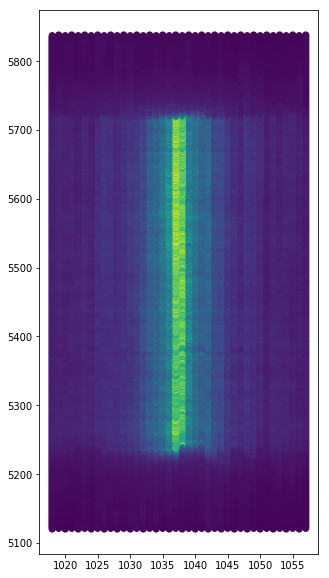

In [15]:
plt.figure(figsize=(5, 10))
plt.scatter(traces_max_inline, traces_max_xline, c=traces_max_value)
plt.show()

### Conclusion
We have successfully performed a calculation on a 180GB seismic SEGY file without having to spin up or down a single computer, minus this notebook.  All at the cost of $0.67 and 6.5 minutes of processing time.  This process is scalable and repeatable.

In [24]:
print(np.shape(trace_locations))
print(np.shape(trace_xline))
print(np.shape(trace_bundle))

(0,)
(9212160,)
(9212160, 3)


In [30]:
temp = trace_bundle
print(trace_bundle[2000][2])

5142


In [11]:
# Get S3 object
segy_obj = s3.Object(source_bucket, f"{source_folder}/{source_filename}")

# Define some needed variables based off the above parameters
start_time = time.time()
header_size = 3600
trace_header_size = 240
trace_size = bin_header['samples_per_trace'] * 4
trace_size_with_headers = trace_size + trace_header_size
filesize = segy_obj.content_length
trace_count = int((filesize - 3600) / trace_size_with_headers)
bundle_size = round(trace_count/concurrent_lambdas)
lambda_counter = 0

lambda_client = boto3.client('lambda')

results_file_list = [] # Lets keep track of the output file names, so we can grab them later

print(f"Total traces in file: {trace_count}")
print(f"Traces per Lambda for {concurrent_lambdas} concurrency (not rounded): {trace_count/concurrent_lambdas}")
print(f"Traces per Lambda, rounded up: {round(trace_count/concurrent_lambdas+0.5)}")

# Send the trace bundle information over to Lambda
for bundle in range(0, int(trace_count), bundle_size):
    lambda_counter = lambda_counter + 1
    bytes_start = bundle * trace_size_with_headers + header_size
    bytes_stop = (bundle + bundle_size) * trace_size_with_headers + header_size - 1
    print(f"Lambda #{lambda_counter}, bundled traces: {bundle}-{bundle+bundle_size}, bytes: {bytes_start}-{bytes_stop}.")
    

    results_file_list.append(f"{mean_amp_folder}/{source_filename}.{bytes_start}-{bytes_stop}.pkl")
    
print("Done!  Elapse time to gather traces and send to Lambda: {:0.2f} seconds, now waiting a bit for processing to complete.".format(time.time() - start_time))


Total traces in file: 9212160
Traces per Lambda for 1000 concurrency (not rounded): 9212.16
Traces per Lambda, rounded up: 9213
Lambda #1, bundled traces: 0-9212, bytes: 3600-186454479.
Lambda #2, bundled traces: 9212-18424, bytes: 186454480-372905359.
Lambda #3, bundled traces: 18424-27636, bytes: 372905360-559356239.
Lambda #4, bundled traces: 27636-36848, bytes: 559356240-745807119.
Lambda #5, bundled traces: 36848-46060, bytes: 745807120-932257999.
Lambda #6, bundled traces: 46060-55272, bytes: 932258000-1118708879.
Lambda #7, bundled traces: 55272-64484, bytes: 1118708880-1305159759.
Lambda #8, bundled traces: 64484-73696, bytes: 1305159760-1491610639.
Lambda #9, bundled traces: 73696-82908, bytes: 1491610640-1678061519.
Lambda #10, bundled traces: 82908-92120, bytes: 1678061520-1864512399.
Lambda #11, bundled traces: 92120-101332, bytes: 1864512400-2050963279.
Lambda #12, bundled traces: 101332-110544, bytes: 2050963280-2237414159.
Lambda #13, bundled traces: 110544-119756, bytes

In [10]:
s3_client = boto3.client('s3')

trace_mean_amp = []
trace_inline = []
trace_xline = []
trace_locations = []
traces = []
start_time = time.time()

# Iterate through the files
for x in range(0, len(results_file_list)):
    print("Reading file: ", results_file_list[x])
    
    # Get file from S3, convert from Pickle format
    object = s3_client.get_object(Bucket=results_bucket, Key=results_file_list[x])
    serializedObject = object['Body'].read()
    trace_bundle_temp = pickle.loads(serializedObject)
    
    # Split the tuple [1,2,3] into seperate variables for easier use
    for y in range(0, len(trace_bundle_temp)):
        #trace_mean_amp.append(trace_bundle_temp[y][0])
        #trace_inline.append(trace_bundle_temp[y][1])
        #trace_xline.append(trace_bundle_temp[y][2])
        traces.append(trace_bundle_temp[y])

print("Number of traces loaded: {}, elapsed time: {:0.2f} seconds.".format(len(trace_mean_amp), time.time() - start_time))


NameError: name 'results_file_list' is not defined

In [16]:
traces_grouped = {}
traces_max = {}

counter = 0
for trace in traces:
    counter = counter + 1
    #print(trace)
    group = f"{trace[1]}-{trace[2]}"
    #print(group)
    if group in traces_grouped:
        traces_grouped[str(group)].append(trace[0])
    else:
        traces_grouped[str(group)] = [trace[0]]
    #print(traces_grouped)
    #if (counter > 10):
    #    break

for group in traces_grouped:
    #print(traces_grouped[group])
    traces_max[group] = np.amax(traces_grouped[group])
    #print(traces_max[group])

In [18]:
print(len(traces_max))

28720


In [50]:
traces_max_value = []
traces_max_inline = []
traces_max_xline = []

counter = 0
for group in traces_max:
    inline = int(group.split("-")[0])
    xline = int(group.split("-")[1])
    #print(f"Inline: {inline}, Xline: {xline}, Counter: {counter}, Group: {group}.")
    
    traces_max_inline.append(inline)
    traces_max_xline.append(xline)
    traces_max_value.append(traces_max[group])
    counter = counter + 1


31641.172048236083
34225.52706972046
30859.87752892151
34348.50857075806
33513.16123625793
37150.269686578366
35791.20420355835
35651.22551288452
36893.00202978821
37819.60523807373
37224.74315506592
38952.12192137146
37714.99050907288
36348.59455185852
35663.64430716858
37487.434693206786
38656.75168040161
37508.33896901245
38744.75860105896
39117.13978526001
37005.47109766846
37303.083573324584
39613.80472692566
41845.622248040774
40762.43235640564
42169.602983407596
42000.168034674076
44616.194811651614
41762.30105434265
42171.308138961795
40955.6047864563
48308.22858203735
44586.254970446775
42321.96039467468
43419.663456604
42794.32462816773
45724.55808218079
44816.96625058899
44979.07082157898
45138.85247306824
42146.05399541626
44319.93822599182
42715.997646463016
47071.59401110535
47552.57763580627
46927.453310876466
46345.68146445923
50423.817630825804
44777.74884968567
45186.715837350464
44659.547170126345
44306.700705557254
46601.901764541624
46121.96563876648
49593.65266696

122102.87933618775
137320.93081474
96166.33978215027
96614.51022461243
120650.27530829163
127212.66233136597
93350.30721026001
99975.04438804627
109103.21980132446
109601.34843218689
98761.71732491456
94776.08571911926
113124.37655907898
102280.7579723114
100725.32511404419
83592.88618795166
116117.7523499054
98763.75830563354
105412.50162488708
92375.49085550537
114725.95431825561
109515.58364968566
107042.23400262756
99558.30428110657
118200.66215638733
117297.2730929657
96917.74846238708
108194.3788892273
111314.48210523376
118948.51325490723
99566.40057145081
99510.72276746827
116055.83171082458
119202.62537928161
92197.87921849976
107370.69859872437
108624.98859093628
115292.32686505128
93399.35237126464
93217.47124985962
110626.08138607483
112316.99602356262
92528.55997332459
96038.2029684143
116640.69178761292
110544.7738389862
96653.3244784607
91983.2800797699
117839.00923171692
118273.72713755799
96747.29255138856
97251.49011169128
115360.12776276245
112640.49320813904
97078.5

50298.90316462097
50086.478406311035
48057.33838183289
49808.642173846434
50611.48533009949
49614.47654197693
51490.493786251835
49991.74475906067
52502.59332382813
55404.08158572082
53003.68874051819
50335.528934439084
51544.68037829285
48082.941600109865
52335.33285316162
54299.92082441406
50661.402896411135
49390.223504144284
51805.586448236085
50496.42514185791
51146.61547498474
48169.57933263855
50780.36976480713
53315.895187417605
54571.54045519409
54921.11131335754
53484.96773184509
52003.793475268554
53214.75751523743
52471.74029574585
47922.71657896423
46983.93603649902
49097.98122362671
49877.356098886106
95338.73887165832
93848.79801482848
91578.81094316406
89871.79923482971
87885.07208088989
87408.98820705872
87176.80128154602
88442.12665808716
88216.87994259644
84279.11177117309
85874.00345696717
83035.59009888917
82092.55306805114
86575.96332660217
86788.16073680115
82516.43661418151
86071.06913746338
87018.401907547
89835.26745584412
89504.1572326416
84642.10858638001
84

124636.37742359313
133223.05761255798
141402.34100656127
126989.06776257935
131812.61096543274
128700.57693363953
140618.14711784056
120349.6962174469
133634.02450967103
139057.84120230714
133693.64910815124
125155.44997034302
126315.677646521
132914.28758477783
130497.01886815796
125947.63258039551
112193.82617355957
121969.74769300537
118938.17493886719
123545.3064170929
129585.8154809143
127447.13344407959
127251.58524231873
129981.22180458985
116863.81634160156
134128.3535415436
132912.838040036
128262.59619024354
125850.20096614685
133481.8819194397
137822.26703218385
124650.84972110596
120809.57304603272
141003.4580989258
130809.45336807861
121921.99189295655
119506.61516481018
127181.42123087769
126790.53919984437
119768.29997516175
120612.4006090088
128163.2582302185
132019.75934818116
117227.47208360596
116360.31793493958
127975.36189925233
140276.71402344666
118549.83106927491
127745.01424282837
129670.70678022462
134480.4498138794
117935.08470055542
113808.34647212524
132652

164677.2723198822
149009.2132520935
152242.6438691162
129296.40574148865
166692.18306186827
139167.5449900299
147830.63124792784
125036.8731245697
160008.54380177916
143294.4709708069
127737.1464203125
134130.82573877258
144980.1479273041
153860.2657704895
132781.69332347717
138046.6011992035
146564.05780700684
143664.00489791564
139621.34075527955
125339.3452223877
155181.18875997316
131686.85096578675
132089.62945222473
122682.62397216492
146759.67383522645
140141.2315456665
132236.23849693604
134434.85410076295
156043.7364900879
170227.4818835785
144875.51890904846
150167.44084634705
152612.79627251587
157997.22124389344
140871.2254605957
140077.78055556337
161449.1596052185
166540.37604169617
142165.3108637146
141328.7818351532
152730.34135390015
151697.65825133666
143381.3908920746
145413.37611183472
157161.56473714294
156998.61413433228
144500.01085336914
149244.35382792054
151484.50926965332
149641.85528818055
147670.78317001954
144852.6422100189
153419.61436338807
149659.309332

137264.56798518676
147027.21160662538
142881.0053854828
153993.50485613404
112045.38904128113
113805.75525697938
98978.8012445404
99077.83137780761
102246.77709814758
104947.13200992432
107957.94865438843
104838.73168321533
91332.92890921936
99343.39477087707
80733.17886685791
79046.54754725342
87526.19733757325
80851.0715210968
89680.31861593017
90676.62922017212
76091.03319649963
80816.15092065735
85769.7515139679
81516.47354814758
82538.88495513305
87967.17115213317
76457.39972191773
72559.34536439819
71450.3777873291
71245.2426520691
73714.20264150086
67871.49770689392
68449.9398831482
68628.5316460968
64085.22699581299
62860.072132724
57846.67258910523
60540.086593740845
63789.629000857545
58654.644595114136
57041.86915076599
57921.95183173828
57157.25154888611
56648.73159098205
61125.940005667115
58856.66479390564
61313.809012313846
60611.64668409119
58764.669928256226
59214.61299021912
54308.70131149597
55697.23675548706
50145.350786904906
50389.286196786496
50121.00954076538
48

43444.31366399536
42008.12954008789
41692.58001517334
301852.7085484009
304201.6386937317
313111.20073601074
287414.287192218
295089.17405625916
266841.9508552063
270698.6670375336
278128.67697486875
270508.877862616
320610.9735247406
339524.5485522583
308031.38117388
323833.3272128235
311635.3701315796
322230.5403166321
318255.39219179074
320681.6450115326
317288.5811675018
287825.6045183014
282231.5613162842
294505.5219174042
280061.2594603241
299203.50797438354
295357.93448738096
321362.12256237486
314544.91001920775
328477.7277392975
315004.9663948608
312568.01336781314
313549.1129857239
324215.4529930725
326134.93214158935
323158.2714891876
315188.1485914337
332141.768409552
312836.304152417
326595.9781208649
288082.429042923
292571.90545379027
295741.8584534973
316553.7766242828
307708.77095287474
375270.7877557983
357984.0405815216
342838.3069369385
315434.1359807068
336165.71846452024
323350.7857162567
319973.1597476074
297097.3268255554
325918.8295584961
331780.8692284119
3087

417676.68663727416
587760.0492151886
645731.4390897553
382145.7059071137
368206.7159437256
663757.3300302369
545646.9061406922
389778.4326388428
357429.37722762756
546685.8157194824
646874.8586184967
383498.7411146515
329763.94709243777
679961.6578365448
563746.7663602356
365530.66130600584
376535.31988832704
527628.7913195984
601633.5786974517
355572.06213519594
341635.19539683836
645683.8596280853
563572.7334323761
353399.5109194275
362169.0639050476
581722.2774103271
680729.5365858123
331324.4784391327
341808.06920574344
616137.9489336243
587475.8937433624
366460.34724638367
382619.77452951967
544338.5140893493
637722.3187239532
347820.7994488037
330591.6389726563
625703.548229251
559900.1045564422
355526.3064743195
355260.8781339691
527802.1534052185
633848.367845929
345876.86208049924
330578.56285380246
613487.2372751404
536252.32622612
360820.74086593324
341669.96766644897
554911.7803925232
637582.984051538
357348.64857643127
342905.4618557892
628617.5950423034
599596.6287518769


180617.50439843445
179039.69119167177
129550.66705572509
138281.2590784485
156027.37045541994
173899.12117050475
126341.9258954071
138371.64296488036
159598.610684021
176343.74081925355
132613.3595251526
137707.54302680664
167555.38859944764
168020.28641744994
130519.96368127136
131399.45574784547
166956.2430086548
177519.87777910157
135891.64649720764
133093.60520569154
180010.8416139618
182628.15684933777
132650.99311547852
136543.2475330719
175040.24431719971
185938.33117349548
143266.3971191742
134980.92715517883
188702.8347534668
173288.34837779542
132942.4552155884
126569.82997721863
177276.26595102844
170060.78425184326
127710.7521566864
129427.48373773193
176670.91488661803
173403.959319516
125830.84098856812
140101.1829987671
160882.75968875122
176879.74184493715
128140.2468533905
140260.61457376098
174055.46815779113
189483.34930090333
135090.05278160094
144919.69227761537
181515.6854644165
196363.7720321594
149083.16247314148
145235.11951498108
193644.1911409424
184560.67091

49736.115320269775
54089.50976286621
54442.75915365601
57316.73861788635
52240.73401103516
53105.08121156922
52554.390209646604
49660.60795484009
52302.197835858155
49824.49821448059
49352.255025219725
51653.99438297424
48316.91519595337
50014.28717429809
52621.45297026367
52313.34124458313
53380.79577133789
51358.34226512756
52388.12381563416
58140.700611279295
55224.013126226804
64633.63590906372
59827.33145952454
65058.834791622925
60482.66381226807
63231.99640494385
57575.96621804199
61402.11142167664
60113.77329042358
58136.67226871338
63830.79252174377
62219.655526400755
62408.37027791443
69785.68467537231
70293.14428916016
74278.42623551941
71355.67131977539
83675.6704418335
73310.16259903564
78056.8295305725
69954.74381718446
78026.90300402221
76992.61028839111
72433.81310112
74684.6010592987
80442.3463991272
73807.16372850646
79740.00998159485
83110.61405631714
80040.07911584472
90465.26497997437
97372.17525962525
88500.7439547821
102254.81941098633
89596.21851224365
91371.662

42048.783204519656
41448.48345862122
46482.14272613831
42678.95553054504
45437.27023381348
43106.5576448822
42220.487408609006
43277.899212506105
42154.09621661987
41451.732662347415
42105.88358461304
44269.49732243347
43840.485799890135
42255.94509641113
41965.03227163086
46037.40879125977
43837.545099783325
42294.356557901
46476.94662652893
44671.77807212524
42377.973476190185
45014.81046549072
42632.125848013304
43918.53052982788
44856.39803432617
41566.20192877502
41037.23451832275
46330.81885806885
41599.13583869324
39640.60305205383
40668.80006022949
42470.35714667664
42130.614240042116
42853.86835543518
41625.89352629395
40116.67263258362
42082.97899490662
39435.052337908935
39367.80175890198
41865.43875707092
43498.29940534668
41687.53214183349
41018.437926141356
42884.492939013675
41277.3433476593
42020.414247540284
41676.58989764099
40911.097818170165
39670.99927383728
43825.139799365235
41919.22301613159
41135.659778805544
41303.67130554199
38011.931679919435
41892.827682385

87485.75821647949
80995.32043423461
86808.47451477051
94927.67782291259
83737.8052457489
84110.50898566285
80235.80188976746
95893.68643085632
84724.22130966187
88117.12540522155
85795.36780661315
93218.77332875367
90331.87818082886
86907.81297134704
80723.92861637268
93104.5587122589
90466.91632570495
93731.0663237732
82852.59455054931
94496.10120589599
88198.71517500305
87456.16761550293
85624.46930299072
93418.92696929627
93724.51406074829
87062.29177681274
83437.69602097168
96948.82876812744
89782.90593199462
89888.93070738525
86827.3244344635
87640.94817042236
84082.31445093689
84676.69333389282
88558.6370315094
96263.91915360413
84102.06394493714
86114.64967124938
87132.11996342469
96197.00476572265
95830.46346598206
81838.72310630493
85104.59103652954
90911.17976661377
90502.64308289795
88348.17252008057
87405.35084789734
82641.43147229614
87666.0555580658
88655.45027965393
87595.01821818847
83039.89965987549
79923.67618545532
85123.33307057801
87705.17781484986
85457.7327271331

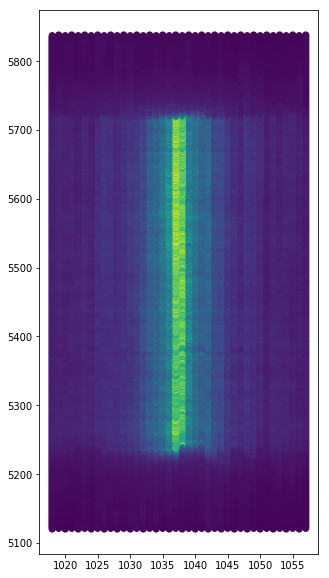

In [54]:
plt.figure(figsize=(5, 10))
plt.scatter(traces_max_inline, traces_max_xline, c=traces_max_value)
plt.show()